In [1]:
import librosa
import librosa.display
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,AveragePooling2D,ZeroPadding2D,BatchNormalization

Using TensorFlow backend.


In [57]:
y, sr = librosa.load('/home/daniel/datatest/nine/d8ee4734_nohash_0.wav',sr=16000,duration=10)

In [58]:
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.title('Monophonic')

In [59]:
plt.figure(figsize=(12, 8))
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [60]:
plt.subplot(4, 2, 2)
librosa.display.specshow(D, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

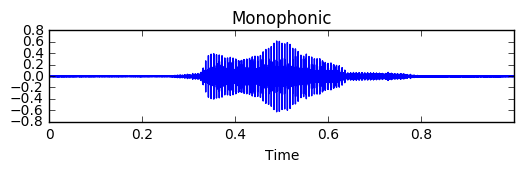

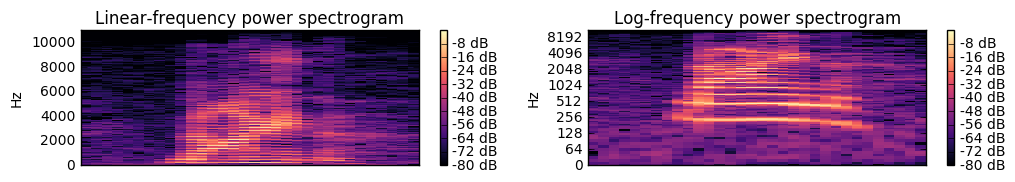

In [61]:
plt.show()

In [50]:
DATA_PATH = "/home/daniel/data/"

In [51]:
# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)

In [52]:
import numpy as np
import os

DATA_PATH = "/home/daniel/data/"

# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)


In [53]:
labels, _, _ = get_labels(DATA_PATH)
labels

['marvin',
 'happy',
 'six',
 'up',
 'stop',
 'yes',
 'sheila',
 'zero',
 'dog',
 'right',
 'house',
 'no',
 'two',
 'left',
 'cat',
 'nine',
 'seven',
 'three',
 'wow',
 'bed']

In [55]:
# Handy function to convert wav2mfcc
def wav2mfcc(file_path, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=16000,n_mfcc=26)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

In [56]:
def save_data_to_array(path=DATA_PATH, max_len=11):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in wavfiles:
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
        np.save(label + '.npy', mfcc_vectors)

In [57]:
def get_train_test(split_ratio=0.8, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))
        print label
    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)

In [58]:
def prepare_dataset(path=DATA_PATH):
    labels, _, _ = get_labels(path)
    data = {}
    for label in labels:
        data[label] = {}
        data[label]['path'] = [path  + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]

        vectors = []

        for wavfile in data[label]['path']:
            wave, sr = librosa.load(wavfile, mono=True, sr=None)
            # Downsampling
            wave = wave[::3]
            mfcc = librosa.feature.mfcc(wave, sr=16000,n_mfcc=26)
            vectors.append(mfcc)

        data[label]['mfcc'] = vectors

    return data

In [59]:
def load_dataset(path=DATA_PATH):
    data = prepare_dataset(path)

    dataset = []

    for key in data:
        for mfcc in data[key]['mfcc']:
            dataset.append((key, mfcc))

    return dataset[:100]

In [60]:

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Conv1D
from keras.utils import to_categorical

# Second dimension of the feature is dim2
feature_dim_2 = 11

# Save data to array file first
save_data_to_array(max_len=feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
feature_dim_1 = 26
channel = 1
epochs = 15
batch_size = 100
verbose = 1
num_classes = 20

# Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

happy
six
up
stop
yes
sheila
zero
dog
right
house
no
two
left
cat
nine
seven
three
wow
bed


In [61]:
# Predicts one sample
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    return get_labels()[0][
            np.argmax(model.predict(sample_reshaped))
    ]

In [62]:
def model_lenet():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(5, 5), strides=1, activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5),strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(62, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [63]:
model = model_lenet()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/15
27200/27200 [==============================] - 11s 411us/step - loss: 2.8934 - acc: 0.1265 - val_loss: 2.0955 - val_acc: 0.3351
Epoch 2/15
27200/27200 [==============================] - 11s 398us/step - loss: 1.3934 - acc: 0.5617 - val_loss: 1.1198 - val_acc: 0.6453
Epoch 3/15
27200/27200 [==============================] - 11s 399us/step - loss: 0.8595 - acc: 0.7309 - val_loss: 0.8942 - val_acc: 0.7197
Epoch 4/15
27200/27200 [==============================] - 11s 403us/step - loss: 0.6657 - acc: 0.7900 - val_loss: 0.7381 - val_acc: 0.7697
Epoch 5/15
27200/27200 [==============================] - 11s 409us/step - loss: 0.5491 - acc: 0.8263 - val_loss: 0.7024 - val_acc: 0.7862
Epoch 6/15
27200/27200 [==============================] - 10s 382us/step - loss: 0.4647 - acc: 0.8518 - val_loss: 0.6478 - val_acc: 0.8093
Epoch 7/15
27200/27200 [==============================] - 10s 380us/step - loss: 0.4013 - acc: 0.8729 - val_loss: 0.6

In [64]:
def model_lenet_modk2():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(2, 2), strides=1, activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    #model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(2, 2),strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [65]:
model = model_lenet_modk2()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/15
27200/27200 [==============================] - 7s 253us/step - loss: 3.3691 - acc: 0.3327 - val_loss: 1.4336 - val_acc: 0.5519
Epoch 2/15
27200/27200 [==============================] - 7s 241us/step - loss: 1.1670 - acc: 0.6397 - val_loss: 1.0608 - val_acc: 0.6713
Epoch 3/15
27200/27200 [==============================] - 7s 241us/step - loss: 0.8277 - acc: 0.7428 - val_loss: 0.8587 - val_acc: 0.7357
Epoch 4/15
27200/27200 [==============================] - 7s 248us/step - loss: 0.6376 - acc: 0.7977 - val_loss: 0.7945 - val_acc: 0.7579
Epoch 5/15
27200/27200 [==============================] - 7s 248us/step - loss: 0.5036 - acc: 0.8431 - val_loss: 0.8787 - val_acc: 0.7424
Epoch 6/15
27200/27200 [==============================] - 7s 241us/step - loss: 0.4003 - acc: 0.8722 - val_loss: 0.7774 - val_acc: 0.7760
Epoch 7/15
27200/27200 [==============================] - 7s 250us/step - loss: 0.3106 - acc: 0.9002 - val_loss: 0.7212 - v

In [66]:
def model_lenet_modk3():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(3, 3), strides=1, activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    #model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(3, 3),strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [67]:
model = model_lenet_modk3()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/15
27200/27200 [==============================] - 6s 237us/step - loss: 2.1856 - acc: 0.3608 - val_loss: 1.3131 - val_acc: 0.5856
Epoch 2/15
27200/27200 [==============================] - 6s 216us/step - loss: 1.1779 - acc: 0.6312 - val_loss: 1.0672 - val_acc: 0.6690
Epoch 3/15
27200/27200 [==============================] - 6s 222us/step - loss: 0.8764 - acc: 0.7249 - val_loss: 0.9139 - val_acc: 0.7172
Epoch 4/15
27200/27200 [==============================] - 6s 219us/step - loss: 0.7069 - acc: 0.7787 - val_loss: 0.8068 - val_acc: 0.7516
Epoch 5/15
27200/27200 [==============================] - 6s 217us/step - loss: 0.5974 - acc: 0.8097 - val_loss: 0.7989 - val_acc: 0.7519
Epoch 6/15
27200/27200 [==============================] - 6s 219us/step - loss: 0.5038 - acc: 0.8397 - val_loss: 0.7263 - val_acc: 0.7794
Epoch 7/15
27200/27200 [==============================] - 6s 222us/step - loss: 0.4276 - acc: 0.8633 - val_loss: 0.7229 - v

In [68]:
def model_lenet_modk4():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(4, 4), strides=1, activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(4, 4),strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [69]:
model = model_lenet_modk4()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/15
27200/27200 [==============================] - 14s 500us/step - loss: 2.4584 - acc: 0.4143 - val_loss: 1.1727 - val_acc: 0.6312
Epoch 2/15
27200/27200 [==============================] - 14s 532us/step - loss: 0.9593 - acc: 0.6984 - val_loss: 0.9273 - val_acc: 0.7141
Epoch 3/15
27200/27200 [==============================] - 13s 494us/step - loss: 0.6790 - acc: 0.7862 - val_loss: 0.7790 - val_acc: 0.7544
Epoch 4/15
27200/27200 [==============================] - 14s 517us/step - loss: 0.5117 - acc: 0.8400 - val_loss: 0.6842 - val_acc: 0.7926
Epoch 5/15
27200/27200 [==============================] - 14s 508us/step - loss: 0.4048 - acc: 0.8725 - val_loss: 0.6594 - val_acc: 0.8029
Epoch 6/15
27200/27200 [==============================] - 15s 548us/step - loss: 0.3210 - acc: 0.8970 - val_loss: 0.6721 - val_acc: 0.8079
Epoch 7/15
27200/27200 [==============================] - 14s 521us/step - loss: 0.2411 - acc: 0.9216 - val_loss: 0.6

In [70]:
def model_lenet_modk6():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(6, 6), strides=1, activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(6, 6),strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [71]:
model = model_lenet_modk6()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/15
27200/27200 [==============================] - 11s 387us/step - loss: 1.9921 - acc: 0.4011 - val_loss: 1.1845 - val_acc: 0.6279
Epoch 2/15
27200/27200 [==============================] - 11s 405us/step - loss: 1.0223 - acc: 0.6790 - val_loss: 0.8051 - val_acc: 0.7476
Epoch 3/15
27200/27200 [==============================] - 11s 395us/step - loss: 0.7485 - acc: 0.7653 - val_loss: 0.8415 - val_acc: 0.7401
Epoch 4/15
27200/27200 [==============================] - 11s 391us/step - loss: 0.6048 - acc: 0.8061 - val_loss: 0.6809 - val_acc: 0.7896
Epoch 5/15
27200/27200 [==============================] - 11s 392us/step - loss: 0.5135 - acc: 0.8336 - val_loss: 0.6284 - val_acc: 0.8019
Epoch 6/15
27200/27200 [==============================] - 11s 394us/step - loss: 0.4330 - acc: 0.8617 - val_loss: 0.6391 - val_acc: 0.8131
Epoch 7/15
27200/27200 [==============================] - 11s 399us/step - loss: 0.3745 - acc: 0.8776 - val_loss: 0.6

In [35]:
print(predict('/home/daniel/datatest/nine/d8ee4734_nohash_0.wav', model=model))

nine


In [73]:
def model_spnet():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(5, 5), activation='relu',strides=4, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5), activation='relu'))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5), strides=1, activation='relu'))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [74]:
model = model_spnet()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/15
27200/27200 [==============================] - 9s 321us/step - loss: 2.0722 - acc: 0.3542 - val_loss: 1.5694 - val_acc: 0.4999
Epoch 2/15
27200/27200 [==============================] - 8s 288us/step - loss: 1.1994 - acc: 0.6182 - val_loss: 1.0405 - val_acc: 0.6750
Epoch 3/15
27200/27200 [==============================] - 9s 329us/step - loss: 0.9382 - acc: 0.7012 - val_loss: 0.9673 - val_acc: 0.6925
Epoch 4/15
27200/27200 [==============================] - 9s 314us/step - loss: 0.7975 - acc: 0.7422 - val_loss: 0.9034 - val_acc: 0.7174
Epoch 5/15
27200/27200 [==============================] - 9s 314us/step - loss: 0.7141 - acc: 0.7668 - val_loss: 0.8823 - val_acc: 0.7278
Epoch 6/15
27200/27200 [==============================] - 9s 313us/step - loss: 0.6368 - acc: 0.7911 - val_loss: 0.8453 - val_acc: 0.7443
Epoch 7/15
27200/27200 [==============================] - 9s 322us/step - loss: 0.5737 - acc: 0.8111 - val_loss: 0.8716 - v

In [40]:
spnet = {}
lenet = {}
lenet_k2 = {}
lenet_k3 = {}
lenet_k4 = {}
lenet_k6 = {}

In [41]:
spnet[1] = 0.3508; spnet[2] = 0.6067; spnet[3] = 0.6896; spnet[4] = 0.7335; spnet[5] = 0.7624; spnet[6] = 0.7816; spnet[7] = 0.7963;
spnet[8] = 0.8164; spnet[9] = 0.8297; spnet[10] = 0.8421; spnet[11] = 0.8569; spnet[12] = 0.8661; spnet[13] = 0.8756; spnet[14]= 0.8849; spnet[15] = 0.8979

In [42]:
lenet[1] = 0.2889; lenet[2] = 0.6210; lenet[3] = 0.7281; lenet[4] = 0.7839; lenet[5] = 0.8167; lenet[6] = 0.8417; lenet[7] = 0.8634; lenet[8] = 0.8784; 
lenet[9] = 0.8936; lenet[10] = 0.9084; lenet[11] = 0.9196; lenet[12] = 0.9317; lenet[13] = 0.9431; lenet[14] = 0.9528; lenet[15] = 0.9553; 

In [43]:
lenet_k2[1] = 0.3346; lenet_k2[2] = 0.6183; lenet_k2[3] = 0.7183; lenet_k2[4] = 0.7811; lenet_k2[5] = 0.8225; lenet_k2[6] = 0.8503; lenet_k2[7] = 0.8822; lenet_k2[8] = 0.9076; 
lenet_k2[9] = 0.9258; lenet_k2[10] = 0.9433; lenet_k2[11] = 0.9571; lenet_k2[12] = 0.9651; lenet_k2[13] = 0.9754; lenet_k2[14] = 0.9808; lenet_k2[15] = 0.9851;

In [44]:
lenet_k3[1] = 0.3361; lenet_k3[2] = 0.6151; lenet_k3[3] = 0.7065; lenet_k3[4] = 0.7559; lenet_k3[5] = 0.7882; lenet_k3[6] = 0.8132; lenet_k3[7] = 0.8308; lenet_k3[8] = 0.8459; 
lenet_k3[9] = 0.8630; lenet_k3[10] = 0.8725; lenet_k3[11] = 0.8904; lenet_k3[12] = 0.8988; lenet_k3[13] = 0.9088; lenet_k3[14] = 0.9190; lenet_k3[15] = 0.9302;

In [45]:
lenet_k4[1] = 0.3515; lenet_k4[2] = 0.6751; lenet_k4[3] = 0.7745; lenet_k4[4] = 0.8201; lenet_k4[5] = 0.8541; lenet_k4[6] = 0.8788; lenet_k4[7] = 0.9000; lenet_k4[8] = 0.9173;
lenet_k4[9] = 0.9337; lenet_k4[10] = 0.9481; lenet_k4[11] = 0.9574; lenet_k4[12] = 0.9682; lenet_k4[13] = 0.9732; lenet_k4[14] = 0.9779; lenet_k4[15] = 0.9840; 

In [46]:
lenet_k6[1] = 0.4251; lenet_k6[2] = 0.6827; lenet_k6[3] = 0.7660; lenet_k6[4] = 0.8033; lenet_k6[5] = 0.8368; lenet_k6[6] = 0.8544; lenet_k6[7] = 0.8724; lenet_k6[8] = 0.8867; 
lenet_k6[9] = 0.9007; lenet_k6[10] = 0.9112; lenet_k6[11] = 0.9264; lenet_k6[12] = 0.9350; lenet_k6[13] = 0.9432; lenet_k6[14] = 0.9518; lenet_k6[15] = 0.9610;

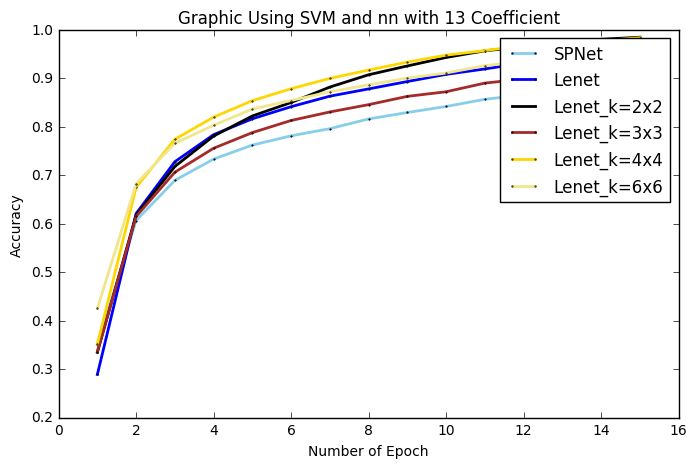

In [47]:
# Data
df=pd.DataFrame({'x': spnet.keys(), 'SPNet': spnet.values(), 'Lenet': lenet.values(), 'Lenet_k=2x2':lenet_k2.values(), 'Lenet_k=3x3':lenet_k3.values(), 'Lenet_k=4x4':lenet_k4.values(), 'Lenet_k=6x6':lenet_k6.values()})
 
# multiple line plot
plt.figure(figsize=(8,5))
plt.plot( 'x', 'SPNet', data=df, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=2)
plt.plot( 'x', 'Lenet', data=df, marker='o', markerfacecolor='blue', markersize=1, color='blue', linewidth=2)
plt.plot( 'x', 'Lenet_k=2x2', data=df, marker='o', markerfacecolor='black', markersize=1, color='black', linewidth=2)
plt.plot( 'x', 'Lenet_k=3x3', data=df, marker='o', markerfacecolor='brown', markersize=1, color='brown', linewidth=2)
plt.plot( 'x', 'Lenet_k=4x4', data=df, marker='o', markerfacecolor='gold', markersize=1, color='gold', linewidth=2)
plt.plot( 'x', 'Lenet_k=6x6', data=df, marker='o', markerfacecolor='khaki', markersize=1, color='khaki', linewidth=2)
plt.title('Graphic Using SVM and nn with 13 Coefficient')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [49]:
tabel_acc20 = pd.DataFrame([spnet.keys(),spnet.values(),lenet.values(),lenet_k2.values(),lenet_k3.values(),lenet_k4.values(),lenet_k6.values()])
tabel_acc20 = tabel_acc20.T
tabel_acc20.columns = ['number of epoch','SPNet','Lenet','Lenet k=2x2','Lenet k=3x3','Lenet k=4x4','Lenet k=6x6']
tabel_acc20

,number of epoch,SPNet,Lenet,Lenet k=2x2,Lenet k=3x3,Lenet k=4x4,Lenet k=6x6
0,1.0,0.3508,0.2889,0.3346,0.3361,0.3515,0.4251
1,2.0,0.6067,0.6210,0.6183,0.6151,0.6751,0.6827
2,3.0,0.6896,0.7281,0.7183,0.7065,0.7745,0.7660
3,4.0,0.7335,0.7839,0.7811,0.7559,0.8201,0.8033
4,5.0,0.7624,0.8167,0.8225,0.7882,0.8541,0.8368
5,6.0,0.7816,0.8417,0.8503,0.8132,0.8788,0.8544
6,7.0,0.7963,0.8634,0.8822,0.8308,0.9000,0.8724
7,8.0,0.8164,0.8784,0.9076,0.8459,0.9173,0.8867
8,9.0,0.8297,0.8936,0.9258,0.8630,0.9337,0.9007
9,10.0,0.8421,0.9084,0.9433,0.8725,0.9481,0.9112


In [32]:
spnet13 = {}
lenet13 = {}
lenet13_k2 = {}
lenet13_k3 = {}
lenet13_k4 = {}
lenet13_k6 = {}

In [33]:
spnet13[1] = 0.3402; spnet13[2] = 0.5997; spnet13[3] = 0.6831; spnet13[4] = 0.7280; spnet13[5] = 0.7588; spnet13[6] = 0.7806; spnet13[7] = 0.8009; spnet13[8] = 0.8161; 
spnet13[9] = 0.8329; spnet13[10] = 0.8439; spnet13[11] = 0.8558; spnet13[12] = 0.8695; spnet13[13] = 0.8814; spnet13[14] = 0.8938; spnet13[15] = 0.9008; 

In [34]:
lenet13[1] = 0.2751; lenet13[2] = 0.6118; lenet13[3] = 0.7236; lenet13[4] = 0.7722; lenet13[5] = 0.8052; lenet13[6] = 0.8251; lenet13[7] = 0.8476; lenet13[8] = 0.8617; 
lenet13[9] = 0.8747; lenet13[10] = 0.8860; lenet13[11] = 0.9019; lenet13[12] = 0.9100; lenet13[13] = 0.9198; lenet13[14] = 0.9306; lenet13[15] = 0.9361;

In [35]:
lenet13_k2[1] = 0.3768; lenet13_k2[2] = 0.6249; lenet13_k2[3] = 0.7148; lenet13_k2[4] = 0.7646; lenet13_k2[5] = 0.7968; lenet13_k2[6] = 0.8258; lenet13_k2[7] = 0.8461; lenet13_k2[8] = 0.8653; 
lenet13_k2[9] = 0.8815; lenet13_k2[10] = 0.8974; lenet13_k2[11] = 0.9094; lenet13_k2[12] = 0.9252; lenet13_k2[13] = 0.9374; lenet13_k2[14] = 0.9471; lenet13_k2[15] = 0.9556; 

In [36]:
lenet13_k3[1] = 0.3558; lenet13_k3[2] = 0.6108; lenet13_k3[3] = 0.6906; lenet13_k3[4] = 0.7301; lenet13_k3[5] = 0.7643; lenet13_k3[6] = 0.7836; lenet13_k3[7] = 0.7987; lenet13_k3[8] = 0.8150; 
lenet13_k3[9] = 0.8246; lenet13_k3[10] = 0.8361; lenet13_k3[11] = 0.8455; lenet13_k3[12] = 0.8554; lenet13_k3[13] = 0.8641; lenet13_k3[14] = 0.8692; lenet13_k3[15] = 0.8779; 

In [37]:
lenet13_k4[1] = 0.4506; lenet13_k4[2] = 0.7076; lenet13_k4[3] = 0.7900; lenet13_k4[4] = 0.8293; lenet13_k4[5] = 0.8554; lenet13_k4[6] = 0.8786; lenet13_k4[7] = 0.8975; lenet13_k4[8] = 0.9142; 
lenet13_k4[9] = 0.9289; lenet13_k4[10] = 0.9409; lenet13_k4[11] = 0.9520; lenet13_k4[12] = 0.9601; lenet13_k4[13] = 0.9673; lenet13_k4[14] = 0.9744; lenet13_k4[15] = 0.9800; 

In [38]:
lenet13_k6[1] = 0.4218; lenet13_k6[2] = 0.6929; lenet13_k6[3] = 0.7624; lenet13_k6[4] = 0.7981; lenet13_k6[5] = 0.8202; lenet13_k6[6] = 0.8345; lenet13_k6[7] = 0.8550; lenet13_k6[8] = 0.8606; 
lenet13_k6[9] = 0.8728; lenet13_k6[10] = 0.8836; lenet13_k6[11] = 0.8896; lenet13_k6[12] = 0.9001; lenet13_k6[13] = 0.9047; lenet13_k6[14] = 0.9131; lenet13_k6[15] = 0.9193; 

In [39]:
tabel_acc13 = pd.DataFrame([spnet13.keys(),spnet13.values(),lenet13.values(),lenet13_k2.values(),lenet13_k3.values(),lenet13_k4.values(),lenet13_k6.values()])
tabel_acc13 = tabel_acc13.T
tabel_acc13.columns = ['number of epoch','SPNet','Lenet','Lenet k=2x2','Lenet k=3x3','Lenet k=4x4','Lenet k=6x6']
tabel_acc13

,number of epoch,SPNet,Lenet,Lenet k=2x2,Lenet k=3x3,Lenet k=4x4,Lenet k=6x6
0,1.0,0.3402,0.2751,0.3768,0.3558,0.4506,0.4218
1,2.0,0.5997,0.6118,0.6249,0.6108,0.7076,0.6929
2,3.0,0.6831,0.7236,0.7148,0.6906,0.7900,0.7624
3,4.0,0.7280,0.7722,0.7646,0.7301,0.8293,0.7981
4,5.0,0.7588,0.8052,0.7968,0.7643,0.8554,0.8202
5,6.0,0.7806,0.8251,0.8258,0.7836,0.8786,0.8345
6,7.0,0.8009,0.8476,0.8461,0.7987,0.8975,0.8550
7,8.0,0.8161,0.8617,0.8653,0.8150,0.9142,0.8606
8,9.0,0.8329,0.8747,0.8815,0.8246,0.9289,0.8728
9,10.0,0.8439,0.8860,0.8974,0.8361,0.9409,0.8836


In [72]:
spnet26 = {}
lenet26 = {}
lenet26_k2 = {}
lenet26_k3 = {}
lenet26_k4 = {}
lenet26_k6 = {}

In [ ]:
spnet26[1] = ; spnet26[2] = ; spnet26[3] = ; spnet26[4] = ; spnet26[5] = ; spnet26[6] = ; spnet26[7] = ; spnet26[8] = ; 
spnet26[9] = ; spnet26[10] = ; spnet26[11] = ; spnet26[12] = ; spnet26[13] = ; spnet26[14] = ; spnet26[15] = ; 

In [ ]:
lenet26[1] = ; lenet26[2] = ; lenet26[3] = ; lenet26[4] = ; lenet26[5] = ; lenet26[6] = ; lenet26[7] = ; lenet26[8] = ; 
lenet26[9] = ; lenet26[10] = ; lenet26[11] = ; lenet26[12] = ; lenet26[13] = ; lenet26[14] = ; lenet26[15] = ; 

In [ ]:
lenet26_k2[1] = ; lenet26_k2[2] = ; lenet26_k2[3] = ; lenet26_k2[4] = ; lenet26_k2[5] = ; lenet26_k2[6] = ; lenet26_k2[7] = ; lenet26_k2[8] = ; 
lenet26_k2[9] = ; lenet26_k2[10] = ; lenet26_k2[11] = ; lenet26_k2[12] = ; lenet26_k2[13] = ; lenet26_k2[14] = ; lenet26_k2[15] = ; 

In [ ]:
lenet26_k3[1] = ; lenet26_k3[2] = ; lenet26_k3[3] = ; lenet26_k3[4] = ; lenet26_k3[5] = ; lenet26_k3[6] = ; lenet26_k3[7] = ; lenet26_k3[8] = ; 
lenet26_k3[9] = ; lenet26_k3[10] = ; lenet26_k3[11] = ; lenet26_k3[12] = ; lenet26_k3[13] = ; lenet26_k3[14] = ; lenet26_k3[15] = ; 

In [ ]:
lenet26_k4[1] = ; lenet26_k4[2] = ; lenet26_k4[3] = ; lenet26_k4[4] = ; lenet26_k4[5] = ; lenet26_k4[6] = ; lenet26_k4[7] = ; lenet26_k4[8] = ; 
lenet26_k4[9] = ; lenet26_k4[10] = ; lenet26_k4[11] = ; lenet26_k4[12] = ; lenet26_k4[13] = ; lenet26_k4[14] = ; lenet26_k4[15] = ; 

In [ ]:
lenet26_k6[1] = ; lenet26_k6[2] = ; lenet26_k6[3] = ; lenet26_k6[4] = ; lenet26_k6[5] = ; lenet26_k6[6] = ; lenet26_k6[7] = ; lenet26_k6[8] = ; 
lenet26_k6[9] = ; lenet26_k6[10] = ; lenet26_k6[11] = ; lenet26_k6[12] = ; lenet26_k6[13] = ; lenet26_k6[14] = ; lenet26_k6[15] = ; 

In [159]:
print(predict('/home/daniel/datatest/7961485531329.wav', model=model))

left
